In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import librosa
import numpy as np
import matplotlib.pyplot as plt

import random


In [2]:
#IMPORT OUR LIBRARIES
import dataloader
import best_classif_model

cudnn.benchmark = True


In [3]:
#LOAD DATASET
dataset = dataloader.MusicDataset('Data/genres_original','Data/features_30_sec.csv')

Loading:  50  items from dataset
Loading:  100  items from dataset
Loading:  150  items from dataset
Loading:  200  items from dataset
Loading:  250  items from dataset
Loading:  300  items from dataset
Loading:  350  items from dataset
Loading:  400  items from dataset
Loading:  450  items from dataset
Loading:  500  items from dataset
Loading:  550  items from dataset
Loading:  600  items from dataset
Loading:  650  items from dataset
Loading:  700  items from dataset
Loading:  750  items from dataset
Loading:  800  items from dataset
Loading:  850  items from dataset
Loading:  900  items from dataset


In [4]:
#RESNET BLOCK

class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)

In [5]:
#MODEL - GENERATOR
class Generator(nn.Module):
    
    def __init__(self, num_classes=8, conv_dim=64, repeat_num=6):
        super(Generator, self).__init__()
        
        c_dim = num_classes
        
        #upp sampling
        layers = []
        layers.append(nn.Conv2d(1+c_dim, conv_dim, kernel_size=(3, 9), padding=(1, 4), bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(curr_dim, curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 1, kernel_size=7, stride=1, padding=3, bias=False))
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)


In [6]:
#MODEL - DISKRIMINATOR

class Discriminator(nn.Module):
    
    def __init__(self, num_classes):
        super(Discriminator,self).__init__()
        modules = []

        modules.append(nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(8))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(16))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(32))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(64))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(32))
        modules.append(nn.ReLU(inplace = True))
        
        
        modules.append(nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(16))
        modules.append(nn.ReLU(inplace = True))
        
        modules.append(nn.AdaptiveAvgPool2d(output_size = 1))

        self.fc=nn.Linear(in_features=16,out_features=1,bias=True)
        
        self.fc_classif = nn.Linear(in_features=16, out_features = num_classes,bias=True)
        
        self.sequence = nn.Sequential(*modules)


    def forward(self,x):
        y = self.sequence(x)
        y = torch.flatten(y,start_dim=1)
        predict_fake = nn.Sigmoid()(self.fc(y))
        predict_genre = nn.Softmax()(self.fc_classif(y))
        return predict_genre, predict_fake
 

In [7]:
#CREATE INSTANCES

torch.cuda.empty_cache()

discriminator = Discriminator(len(dataset.classes))
generator = Generator(num_classes = len(dataset.classes))

#LOAD BEST CLASSIFIER
#classifier = best_classif_model.Classifier(len(dataset.classes))
#PATH = "model_best.pt"
#classifier.load_state_dict(torch.load(PATH))

#DEVICE
device = torch.device('cuda')
discriminator = discriminator.cuda()
generator = generator.cuda()

In [11]:
#isprobavanje 1
name, spect, label = dataset.__getitem__(1)
spect = spect.reshape(1,spect.size(0),spect.size(1),spect.size(2))

spect = spect.to(device)

y = discriminator(spect)
print(y)

(tensor([[0.1681, 0.1409, 0.0797, 0.1066, 0.1165, 0.0949, 0.1080, 0.0805, 0.1049]],
       device='cuda:0', grad_fn=<SoftmaxBackward>), tensor([[0.5199]], device='cuda:0', grad_fn=<SigmoidBackward>))


C:\Anaconda\envs\psiml_gpu\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [40]:
#isprobavanje 2
label_onehot = torch.zeros(len(dataset.classes)) 
label_onehot[label] = 1
label_onehot = label_onehot.reshape(1,-1)
label_onehot = label_onehot.to(device)
y = generator(spect,label_onehot)
print(y.shape)
print(spect.shape)

torch.Size([1, 1, 128, 1280])
torch.Size([1, 1, 128, 1280])


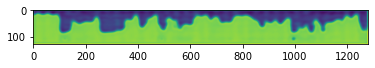

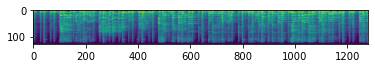

In [41]:
#isprobavanje 3
y = y.detach().cpu().numpy().reshape(y.size(2),y.size(3))
spect = spect.detach().cpu().numpy().reshape(spect.size(2),spect.size(3))
plt.imshow(y)
plt.show()
plt.imshow(spect)

In [8]:
#TRAIN

num_epochs = 1000
batch_size = 5
num_workers = 0
# make train and valid splits

random.seed(0)  # rng seed, set to 0 for reproducibility

dataset_indices = list(range(len(dataset)))
random.shuffle(dataset_indices)  # shuffle the indices before splitting (use random.shuffle)

#split datasets
train_split_indices = dataset_indices[:int(len(dataset_indices)*0.8)]  # get the training split indices
#valid_split_indices = dataset_indices[int(len(dataset_indices)*0.6):int(len(dataset_indices)*0.8)]  # get the validation split indices 
#test_split_indices = dataset_indices[int(len(dataset_indices)*0.8):]

train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_split_indices)
#valid_subset_sampler = torch.utils.data.SubsetRandomSampler(valid_split_indices)
#test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_split_indices)

train_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=train_subset_sampler, num_workers=num_workers, drop_last=True)


d_learning_rate=0.01
g_learning_rate=0.0005
g_optimizer = torch.optim.Adam(generator.parameters(),lr=d_learning_rate)
d_optimizer = torch.optim.Adam(generator.parameters(),lr=g_learning_rate)

n_disc = 10  
    

In [9]:
lambda_class_d = 0.5 #parameter for the "importance" of good classification
lambda_class = 0.5
lambda_cycle = 0.5
lambda_ident = 0
#TODO: parametri wtf


for epoch in range(num_epochs):
    
    for i, (name,spect,label) in enumerate(train_dataloader):
        
        #get labels (c) and convert to onehot
        label_goal = []
        rnd_label = []
        label_onehot = []
        for j in range(batch_size):
            rnd_label.append(random.randint(0,len(dataset.classes)-1))
            label_goal.append(np.zeros(len(dataset.classes)))
            label_goal[j][rnd_label[j]] = 1
            
            label_onehot.append(np.zeros(len(dataset.classes)))
            label_onehot[j][label[j]] = 1
        #print(label)
        #print(label_onehot)
        label_goal = torch.Tensor(label_goal) 
        label_onehot = torch.Tensor(label_onehot)
        
        #print('ucitao labele=',label_goal)
        
        label = label.type(torch.LongTensor)
        rnd_label = torch.Tensor(rnd_label)
        rnd_label = rnd_label.type(torch.LongTensor)
        
        label = label.to(device)
        rnd_label = rnd_label.to(device)
        label_onehot = label_onehot.to(device)
        label_goal = label_goal.to(device)
        spect = spect.to(device)
        
        #print('prebaceno na device\n')
        
        #train discriminator
        genre,fake = discriminator(spect)
        loss_real = - torch.mean(fake)
        loss_class = F.cross_entropy(genre, label)
        
        #print('prosao kroz jedan discr\n')
        #print(label_goal)
        generator_out = generator(spect,label_goal)
            
        #print('prosao kroz gen\n')
        genre, fake = discriminator(generator_out.det
        loss_fake = torch.mean(fake)
        
        #TODO: add gradient penalty 
        
        loss_disc = loss_real + loss_fake + lambda_class_d * loss_class
        
        d_optimizer.zero_grad()
        loss_disc.backward()
        d_optimizer.step()
        if (i%10==0):
            print("loss_disc=",loss_disc.item())
        #train generator
        if (i % n_disc == 0 and epoch>10):
            generator_out = generator(spect,label_goal)
            genre,fake = discriminator(generator_out)
            loss_fake = - torch.mean(fake) #adversary loss
            loss_class = F.cross_entropy(genre, rnd_label) #wrong class
            
            self_inverse = generator(generator_out,label_onehot)
            loss_cycle = torch.mean(torch.abs(self_inverse - spect))
            
            self_out = generator(spect,label_onehot)
            loss_ident = torch.mean(torch.abs(self_out - spect))
            
            loss_gen = loss_fake + lambda_class*loss_class + lambda_cycle * loss_cycle + lambda_ident * loss_ident
            
            g_optimizer.zero_grad()
            loss_gen.backward()
            g_optimizer.step()
            
        if(i%10 == 0 and epoch>10):
            generator_out = generator_out[0].detach().cpu().numpy().reshape(generator_out.size(2),generator_out.size(3))
            plt.imshow(generator_out)
            plt.show()
            print('Loss disc: ',loss_gen.item())
            
    print('Epoch: ',epoch,'\n')
        
        

SyntaxError: invalid syntax (<ipython-input-9-5d037e5b5871>, line 53)

In [71]:
label_goal = label_goal.reshape(1,-1)
print(label_goal.shape)
print(spect.shape)

torch.Size([1, 45])
torch.Size([5, 1, 128, 1280])


In [32]:
generator_out = generator_out[0].detach().cpu().numpy().reshape(generator_out.size(2),generator_out.size(3))

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [38]:
print(generator_out)
audio_signal = librosa.feature.inverse.mel_to_audio(generator_out, sr=22100)
print(audio_signal[10005])
print(audio_signal.shape)
#sf.write('test.wav', audio_signal, sample_rate)

[[ -6.4659634  -8.267063  -10.671354  ... -11.782118   -9.531325
   -6.8890843]
 [ -9.169422  -11.587151  -15.218663  ... -16.226463  -13.424875
   -8.720568 ]
 [-11.612098  -14.330946  -19.147474  ... -20.542433  -16.072922
  -11.741572 ]
 ...
 [-11.690397  -15.772744  -19.517529  ... -24.265465  -18.368486
  -13.887774 ]
 [ -8.503827  -11.911726  -14.932167  ... -19.120691  -13.940987
  -10.561418 ]
 [ -6.9551077  -9.605183  -12.747339  ... -15.1258955 -11.647921
   -8.526837 ]]
1.046313e-11
(654848,)


In [29]:
import soundfile as sf
sf.write('test.wav', audio_signal, 22100)